# Credible set size comparison

see if pcqlts have smaller credible sets overall, or if for the same signal (matched lead variant/colocalized signal) the pcqtl credible set is smaller


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
import ast
import re
from tqdm import tqdm  # for notebooks

import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
from notebook_helper_functions import *
from annotate_clusters import *

#tqdm.pandas()

from scipy.stats import ttest_rel, ranksums
import statsmodels.api as sm


In [5]:
# for posters
# import matplotlib as mpl
# mpl.rcParams['figure.dpi']= 1000

In [6]:
# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/proteincoding_main.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)


# load in the tissue ids 
tissue_df = load_tissue_df(config)
tissue_ids = load_tissue_ids(config)

## colocalization based grouping

In [7]:
my_tissue_id = ['Cells_Cultured_fibroblasts']
underlying_signals = load_across_tissues(config, load_signal_groups, tissue_ids = my_tissue_id)
pc_susie_r = load_across_tissues(config, load_pc_susie_r, tissue_ids = my_tissue_id)
e_susie_r = load_across_tissues(config, load_e_susie_r,  tissue_ids = my_tissue_id)

In [8]:
# add in credible set sizes
for idx, row in tqdm(underlying_signals.iterrows(), total=len(underlying_signals)):
    cs_ids = row['signal_id'].split('-')
    pc_cs_sizes = []
    e_cs_sizes = []
    for cs_id in cs_ids:
        if '_pc' in cs_id:
            pc_cs_sizes.append(len(pc_susie_r[(pc_susie_r['cs_id'] == cs_id) & (pc_susie_r['tissue_id'] == row['tissue_id'])]))
        else:
            e_cs_sizes.append(len(e_susie_r[(e_susie_r['cs_id'] == cs_id) & (e_susie_r['tissue_id'] == row['tissue_id'])]))
    if len(pc_cs_sizes)>0:
        underlying_signals.loc[idx, 'median_pc_cs_size'] = np.median(pc_cs_sizes)
        underlying_signals.loc[idx, 'min_pc_cs_size'] = np.min(pc_cs_sizes)
    if len(e_cs_sizes)>0:
        underlying_signals.loc[idx, 'median_e_cs_size'] = np.median(e_cs_sizes)
        underlying_signals.loc[idx, 'min_e_cs_size'] = np.min(e_cs_sizes)


 ... (more hidden) ...

 ... (more hidden) ...


/local/scratch/klawren/slrmtmp.46845187/ipykernel_26149/2093561760.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multigene_signals['size_diff'] = multigene_signals['median_pc_cs_size'] - multigene_signals['median_e_cs_size']
/local/scratch/klawren/slrmtmp.46845187/ipykernel_26149/2093561760.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multigene_signals['size_diff'] = multigene_signals['size_diff'].clip(-10, 10)


TtestResult(statistic=3.146158408556674, pvalue=0.0018669960392726905, df=236)
RanksumsResult(statistic=2.283225523862249, pvalue=0.022417087383902558)


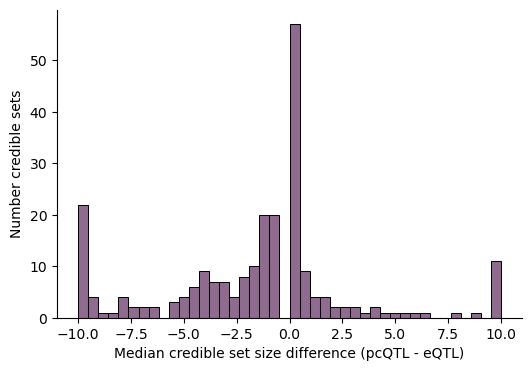

In [9]:
# just multigene signals
multigene_signals = underlying_signals[(underlying_signals['num_e_samelead']>1) & (underlying_signals['num_pc_samelead']>0)]

multigene_signals['size_diff'] = multigene_signals['median_pc_cs_size'] - multigene_signals['median_e_cs_size']
multigene_signals['size_diff'] = multigene_signals['size_diff'].clip(-10, 10)
fig, ax = plt.subplots(figsize=(6,4))
sns.histplot(multigene_signals, x='size_diff', bins = 42, ax=ax, alpha=.8,
             color='#734675')
             #hue='cs_size_label', palette={'eQTL':'#67AFD2','pcQTL':'#B83A4B', 'same size':'#734675'})
ax.set_xlabel('Median credible set size difference (pcQTL - eQTL)')
ax.set_ylabel('Number credible sets')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

print(ttest_rel(multigene_signals['median_e_cs_size'], multigene_signals['median_pc_cs_size']))
print(ranksums(multigene_signals['median_e_cs_size'], multigene_signals['median_pc_cs_size']))

/local/scratch/klawren/slrmtmp.46845187/ipykernel_26149/1475561284.py:14: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0, 250)
/local/scratch/klawren/slrmtmp.46845187/ipykernel_26149/1475561284.py:15: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 250)


(0.7736446291124492, 250)

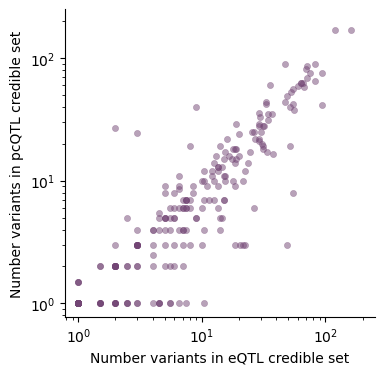

In [10]:
fig, ax = plt.subplots(figsize=(4,4))

sns.scatterplot(multigene_signals, x='median_e_cs_size', y='median_pc_cs_size',
                color='#734675', ax=ax, 
                edgecolor=None, s=20, alpha=.5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Number variants in pcQTL credible set')
ax.set_xlabel('Number variants in eQTL credible set')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlim(0, 250)
ax.set_ylim(0, 250)

/local/scratch/klawren/slrmtmp.46845187/ipykernel_26149/391551215.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multigene_signals['size_diff'] = multigene_signals['min_pc_cs_size'] - multigene_signals['min_e_cs_size']
/local/scratch/klawren/slrmtmp.46845187/ipykernel_26149/391551215.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multigene_signals['size_diff'] = multigene_signals['size_diff'].clip(-10, 10)


TtestResult(statistic=-2.0406315275166382, pvalue=0.04240057658548812, df=236)
RanksumsResult(statistic=-0.45905944223342915, pvalue=0.6461914805696216)


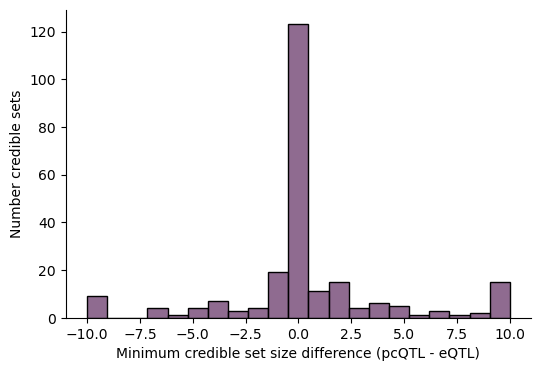

In [11]:

multigene_signals['size_diff'] = multigene_signals['min_pc_cs_size'] - multigene_signals['min_e_cs_size']
multigene_signals['size_diff'] = multigene_signals['size_diff'].clip(-10, 10)
fig, ax = plt.subplots(figsize=(6,4))
sns.histplot(multigene_signals, x='size_diff', bins = 21, ax=ax, alpha=.8,
             color='#734675')
             #hue='cs_size_label', palette={'eQTL':'#67AFD2','pcQTL':'#B83A4B', 'same size':'#734675'})
ax.set_xlabel('Minimum credible set size difference (pcQTL - eQTL)')
ax.set_ylabel('Number credible sets')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

print(ttest_rel(multigene_signals['min_e_cs_size'], multigene_signals['min_pc_cs_size']))
print(ranksums(multigene_signals['min_e_cs_size'], multigene_signals['min_pc_cs_size']))

### matched effect size

In [12]:
susie_annotated = load_across_tissues(config, load_susie_annotated, tissue_ids = my_tissue_id)

def safe_literal_eval(value):
    try:
        if isinstance(value, str):  # Ensure the value is a string
            return ast.literal_eval(value)
        return value  # Return the original if it's not a string
    except (ValueError, SyntaxError):
        # Handle the case where conversion fails
        print(f"Warning: Unable to parse value: {value}")
        return [np.nan]  # You can decide how to handle failures; this returns None

# Apply the safe evaluation function
susie_annotated['egene_qtl_slope'] = susie_annotated['egene_qtl_slope'].apply(safe_literal_eval)

In [13]:
# annotate each eqtl signal group wtih the maximum effect on any egene
susie_annotated['eqtl_max_effect'] = susie_annotated['egene_qtl_slope'].apply(lambda x: max(abs(val) for val in x))

In [16]:
# explode over phenotypes in each underlying signals
underlying_signals['signal_id_list'] = underlying_signals['signal_id'].str.split('-')
underlying_signals_explode = underlying_signals.explode('signal_id_list')
underlying_signals_explode = pd.merge(underlying_signals_explode, susie_annotated[['cs_id', 'eqtl_max_effect', 'tissue_id']].drop_duplicates(), left_on=['signal_id_list', 'tissue_id'], right_on=['cs_id', 'tissue_id'], how='left')
underlying_signals_explode

,signal_id,num_e_samelead,num_pc_samelead,multiple_e,multiple_pc,tissue_id,median_pc_cs_size,min_pc_cs_size,median_e_cs_size,min_e_cs_size,signal_id_list,cs_id,eqtl_max_effect
0,ENSG00000116171.17_ENSG00000121310.16_ENSG0000...,5,1,True,False,Cells_Cultured_fibroblasts,4.0,4.0,5.0,1.0,ENSG00000116171.17_ENSG00000121310.16_ENSG0000...,ENSG00000116171.17_ENSG00000121310.16_ENSG0000...,0.032021
1,ENSG00000116171.17_ENSG00000121310.16_ENSG0000...,5,1,True,False,Cells_Cultured_fibroblasts,4.0,4.0,5.0,1.0,ENSG00000116171.17_ENSG00000121310.16_ENSG0000...,ENSG00000116171.17_ENSG00000121310.16_ENSG0000...,0.033300
2,ENSG00000116171.17_ENSG00000121310.16_ENSG0000...,5,1,True,False,Cells_Cultured_fibroblasts,4.0,4.0,5.0,1.0,ENSG00000116171.17_ENSG00000121310.16_ENSG0000...,ENSG00000116171.17_ENSG00000121310.16_ENSG0000...,0.033934
3,ENSG00000116171.17_ENSG00000121310.16_ENSG0000...,5,1,True,False,Cells_Cultured_fibroblasts,4.0,4.0,5.0,1.0,ENSG00000116171.17_ENSG00000121310.16_ENSG0000...,ENSG00000116171.17_ENSG00000121310.16_ENSG0000...,0.032021
4,ENSG00000116171.17_ENSG00000121310.16_ENSG0000...,5,1,True,False,Cells_Cultured_fibroblasts,4.0,4.0,5.0,1.0,ENSG00000116171.17_ENSG00000121310.16_ENSG0000...,ENSG00000116171.17_ENSG00000121310.16_ENSG0000...,0.033300
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22558,ENSG00000117245.12_ENSG00000189410.11_e_ENSG00...,1,0,False,False,Cells_Cultured_fibroblasts,NaN,NaN,5.0,5.0,ENSG00000117245.12_ENSG00000189410.11_e_ENSG00...,ENSG00000117245.12_ENSG00000189410.11_e_ENSG00...,0.040113
22559,ENSG00000117245.12_ENSG00000189410.11_e_ENSG00...,1,0,False,False,Cells_Cultured_fibroblasts,NaN,NaN,5.0,5.0,ENSG00000117245.12_ENSG00000189410.11_e_ENSG00...,ENSG00000117245.12_ENSG00000189410.11_e_ENSG00...,0.036718
22560,ENSG00000117245.12_ENSG00000189410.11_e_ENSG00...,1,0,False,False,Cells_Cultured_fibroblasts,NaN,NaN,5.0,5.0,ENSG00000117245.12_ENSG00000189410.11_e_ENSG00...,ENSG00000117245.12_ENSG00000189410.11_e_ENSG00...,0.037615
22561,ENSG00000117245.12_ENSG00000189410.11_e_ENSG00...,1,0,False,False,Cells_Cultured_fibroblasts,NaN,NaN,5.0,5.0,ENSG00000117245.12_ENSG00000189410.11_e_ENSG00...,ENSG00000117245.12_ENSG00000189410.11_e_ENSG00...,0.040639


In [19]:
underlying_signals_effect_annotated = underlying_signals_explode.groupby(['signal_id', 'tissue_id']).agg({'median_e_cs_size':'first',
                                                                    'median_pc_cs_size':'first',
                                                                    'num_e_samelead':'first',
                                                                    'num_pc_samelead':'first',
                                                                    'eqtl_max_effect':max})

In [32]:
underlying_signals_effect_annotated = underlying_signals_effect_annotated[~underlying_signals_effect_annotated['eqtl_max_effect'].isna()]
underlying_signals_effect_annotated['size_diff'] = (underlying_signals_effect_annotated['median_pc_cs_size'] - underlying_signals_effect_annotated['median_e_cs_size']).clip(-10, 10)

<AxesSubplot: xlabel='eqtl_max_effect', ylabel='size_diff'>

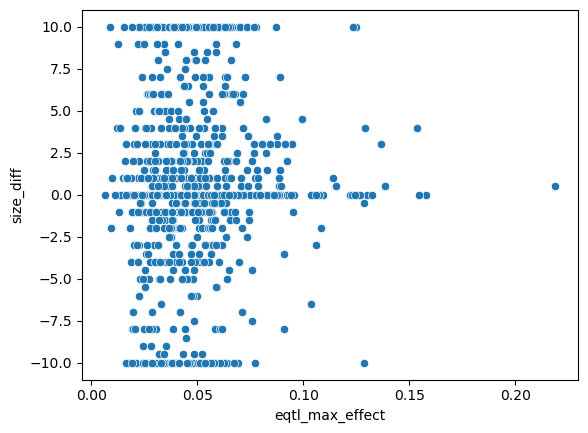

In [35]:
sns.scatterplot(underlying_signals_effect_annotated, y='size_diff', x='eqtl_max_effect')

In [26]:
X = underlying_signals_effect_annotated[['num_e_samelead', 'eqtl_max_effect']]
y = underlying_signals_effect_annotated['num_pc_samelead']

# Add a constant to the independent variables (required for statsmodels)
X = sm.add_constant(X)

# Fit the linear model
model = sm.OLS(y, X).fit()

# Print the summary of the regression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        num_pc_samelead   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     44.80
Date:                Thu, 14 Nov 2024   Prob (F-statistic):           1.07e-19
Time:                        16:05:09   Log-Likelihood:                -1598.8
No. Observations:                1730   AIC:                             3204.
Df Residuals:                    1727   BIC:                             3220.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.6056      0.036     

## lead var grouping

In [3]:
# load in the data from all tissues
susie_annotated = load_across_tissues(config, load_susie_annotated)

# drop cross map ones
clusters = load_across_tissues(config, load_clusters_annotated)
susie_annotated = susie_annotated[~susie_annotated['cluster_id'].isin(clusters[clusters['has_cross_map']]['cluster_id'])]

In [4]:
cs_grouped = susie_annotated.groupby(['phenotype_id', 'cs_id', 'tissue_id']).agg({'lead_variant_id':'first',
                                                                                  'variant_id':list,
                                                                                  'type':'first',
                                                                                  'cluster_id':'first'}).reset_index()

# add pc information to credible sets
cs_grouped['pc_num'] = np.where(cs_grouped['phenotype_id'].str.contains('_pc'), cs_grouped['phenotype_id'].str.split('_pc').str[-1], 0)
cs_grouped['pc_num'] = cs_grouped['pc_num'].astype(int)
cs_grouped['cluster_size'] = cs_grouped['cluster_id'].str.split('_').apply(len)
# split first, last, and middle pcs
cs_grouped['pc_order'] = np.where(cs_grouped['pc_num']==0, 'eqtl', 'middle')
cs_grouped.loc[cs_grouped['pc_num'] == cs_grouped['cluster_size'],'pc_order'] = 'last'
cs_grouped.loc[cs_grouped['pc_num'] == 1,'pc_order'] = 'first'
cs_grouped['num_vars'] = cs_grouped['variant_id'].apply(len)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x2b4b5cd62790>>
Traceback (most recent call last):
  File "/home/klawren/micromamba/envs/tensorqtl_r/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [ ]:
cs_grouped.groupby('pc_order').agg({'num_vars':'mean'})

,num_vars
pc_order,
eqtl,16.327730
first,15.759212
last,19.020080
middle,21.244989


In [36]:
from scipy.stats import mannwhitneyu, ttest_ind

x= cs_grouped[cs_grouped['pc_order']=='eqtl']['num_vars']
y =  cs_grouped[cs_grouped['pc_order']=='first']['num_vars']
print(mannwhitneyu(x,y))
print(ttest_ind(x,y))


MannwhitneyuResult(statistic=84253805.0, pvalue=0.5511108938266769)
Ttest_indResult(statistic=1.0945924485717204, pvalue=0.27370484303950565)


<AxesSubplot: xlabel='num_vars'>

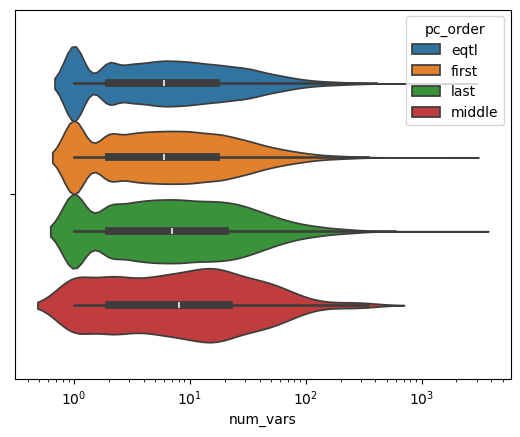

In [37]:
sns.violinplot(cs_grouped, x='num_vars', hue='pc_order', log_scale=True)

In [38]:
# group vep ddf by lead variant
# group by lead variant to prevent varaints from being double counted
lead_var_grouped = cs_grouped.groupby(['lead_variant_id', 'tissue_id', 'cluster_id']).agg({'cs_id':list, 
                                                                                'type':list, 
                                                                                'pc_num':list, 
                                                                                'cluster_size':'first', 
                                                                                'pc_order':list, 
                                                                                'num_vars':list}).reset_index() # you could also do a list of varainces
lead_var_grouped['num_e_samelead'] = lead_var_grouped['cs_id'].astype(str).str.count('_e_')
lead_var_grouped['num_pc_samelead'] = lead_var_grouped['cs_id'].astype(str).str.count('_pc')
lead_var_grouped['exclusive_label'] = np.where((lead_var_grouped['num_e_samelead'] > 0), np.where((lead_var_grouped['num_pc_samelead'] > 0), 'shared', 'eqtl_only'), 'pcqtl_only')

In [39]:
lead_var_grouped.explode(['num_vars', 'pc_order']).groupby(['exclusive_label', 'pc_order']).agg({'num_vars':'mean'})

num_vars
exclusive_label pc_order           
eqtl_only       eqtl       21.25401
pcqtl_only      first     21.966421
                last      23.462795
                middle    26.638978
shared          eqtl       9.870513
                first     10.738201
                last       9.178571
                middle     8.830882

In [40]:
cs_sizes = lead_var_grouped.explode(['pc_order', 'num_vars']).sort_values(by=['lead_variant_id', 'tissue_id', 'cluster_id', 'pc_order']).groupby(['lead_variant_id', 'tissue_id', 'cluster_id', 'pc_order']).agg({'num_vars':min, 'cluster_size':'first', 'num_e_samelead':max}).reset_index()
cs_sizes.groupby('pc_order').agg({'num_vars':'mean'})

,num_vars
pc_order,
eqtl,16.716712
first,15.759212
last,19.022646
middle,21.40699


<AxesSubplot: xlabel='num_vars'>

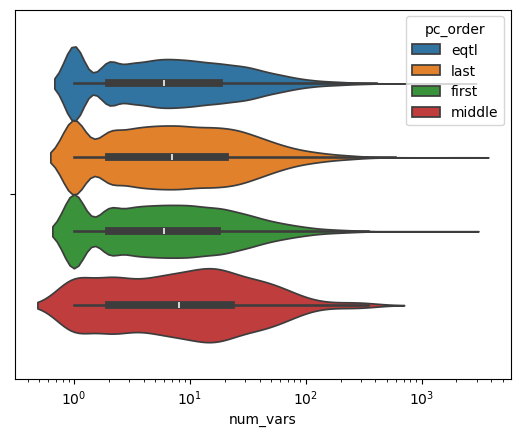

In [41]:
sns.violinplot(cs_sizes, x='num_vars', hue='pc_order', log_scale=True)

In [42]:
x= cs_sizes[cs_sizes['pc_order']=='eqtl']['num_vars'].astype(int)
y = cs_sizes[cs_sizes['pc_order']=='first']['num_vars'].astype(int)
print(mannwhitneyu(x,y))
print(ttest_ind(x,y))

MannwhitneyuResult(statistic=80556279.0, pvalue=0.11089185527792393)
Ttest_indResult(statistic=1.882469724998999, pvalue=0.05978327712858152)


In [43]:
# get the smaller cs for each of the two data types for the shared ones
cs_sizes_shared = lead_var_grouped[lead_var_grouped['exclusive_label']=='shared'].explode(['type', 'num_vars']).sort_values(by=['lead_variant_id', 'tissue_id', 'cluster_id', 'type']).groupby(['lead_variant_id', 'tissue_id', 'cluster_id', 'type']).agg({'num_vars':min, 'cluster_size':'first', 'num_e_samelead':max, 'num_pc_samelead':max})
cs_sizes_pivot = cs_sizes_shared.pivot_table(index=['lead_variant_id', 'cluster_size', 'num_e_samelead', 'num_pc_samelead'], 
                           columns='type', 
                           values='num_vars', 
                           fill_value=0).reset_index()

<AxesSubplot: xlabel='cs_size_label', ylabel='count'>

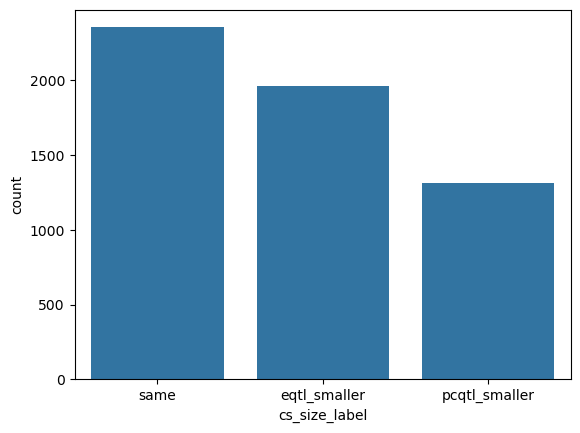

In [44]:
cs_sizes_pivot['cs_size_label'] = np.where(
    cs_sizes_pivot['eqtl'] < cs_sizes_pivot['pcqtl'], 
    'eqtl_smaller', 
    np.where(
        cs_sizes_pivot['eqtl'] > cs_sizes_pivot['pcqtl'], 
        'pcqtl_smaller', 
        'same'
    )
)
sns.countplot(cs_sizes_pivot,  x='cs_size_label')

0.7667022032693674
TtestResult(statistic=-4.774325826567256, pvalue=1.8487676858394518e-06, df=5627)


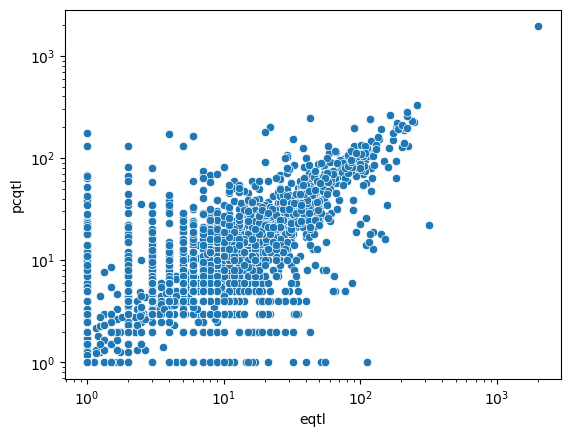

In [45]:
ax = sns.scatterplot(cs_sizes_pivot, x='eqtl', y='pcqtl')
ax.set_xscale('log')
ax.set_yscale('log')
print((cs_sizes_pivot['eqtl'] <= cs_sizes_pivot['pcqtl']).sum()/len(cs_sizes_pivot))
print(ttest_rel(cs_sizes_pivot['eqtl'], cs_sizes_pivot['pcqtl']))

In [46]:
x = cs_sizes_pivot['eqtl']
y = cs_sizes_pivot['pcqtl']
print(np.mean(x))
print(np.mean(y))

print(ttest_rel(x, y))
print(ranksums(x, y))

11.023482551267733
11.877370978050614
TtestResult(statistic=-4.774325826567256, pvalue=1.8487676858394518e-06, df=5627)
RanksumsResult(statistic=-4.032836364290233, pvalue=5.510765413803987e-05)


# look at just multigene clusters

In [47]:
#lead_var_grouped = lead_var_grouped[lead_var_grouped['pc_order'].astype(str).str.contains('first')]

<AxesSubplot: xlabel='cs_size_label', ylabel='count'>

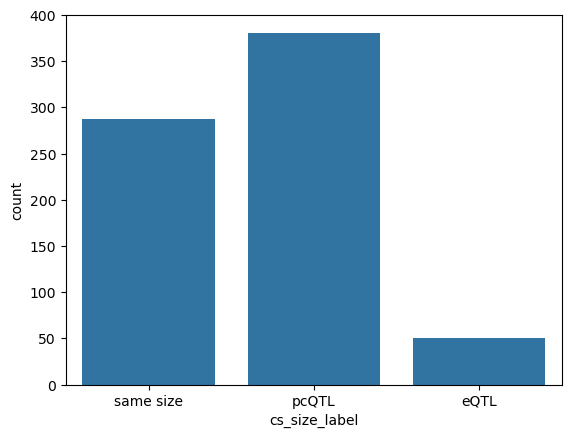

In [48]:
# get the smaller cs for each of the two data types for the shared ones
cs_sizes_shared = lead_var_grouped[(lead_var_grouped['exclusive_label']=='shared')&(lead_var_grouped['num_e_samelead'] > 1)].explode(['type', 'num_vars']).sort_values(by=['lead_variant_id', 'tissue_id', 'cluster_id', 'type']).groupby(['lead_variant_id', 'tissue_id', 'cluster_id', 'type']).agg({'num_vars':'median', 'cluster_size':'first', 'num_e_samelead':max, 'num_pc_samelead':max})
cs_sizes_pivot = cs_sizes_shared.pivot_table(index=['lead_variant_id', 'cluster_size', 'num_e_samelead', 'num_pc_samelead'], 
                           columns='type', 
                           values='num_vars', 
                           fill_value=0).reset_index()
cs_sizes_pivot['cs_size_label'] = np.where(
    cs_sizes_pivot['eqtl'] < cs_sizes_pivot['pcqtl'], 
    'eQTL', 
    np.where(
        cs_sizes_pivot['eqtl'] > cs_sizes_pivot['pcqtl'], 
        'pcQTL', 
        'same size'
    )
)
sns.countplot(cs_sizes_pivot,  x='cs_size_label')

0.46935933147632314
TtestResult(statistic=7.543774769165819, pvalue=1.3863212733196099e-13, df=717)
RanksumsResult(statistic=6.12350719006331, pvalue=9.153772270768593e-10)


/local/scratch/klawren/slrmtmp.46793668/ipykernel_42780/2652910729.py:28: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0, 250)
/local/scratch/klawren/slrmtmp.46793668/ipykernel_42780/2652910729.py:29: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 250)


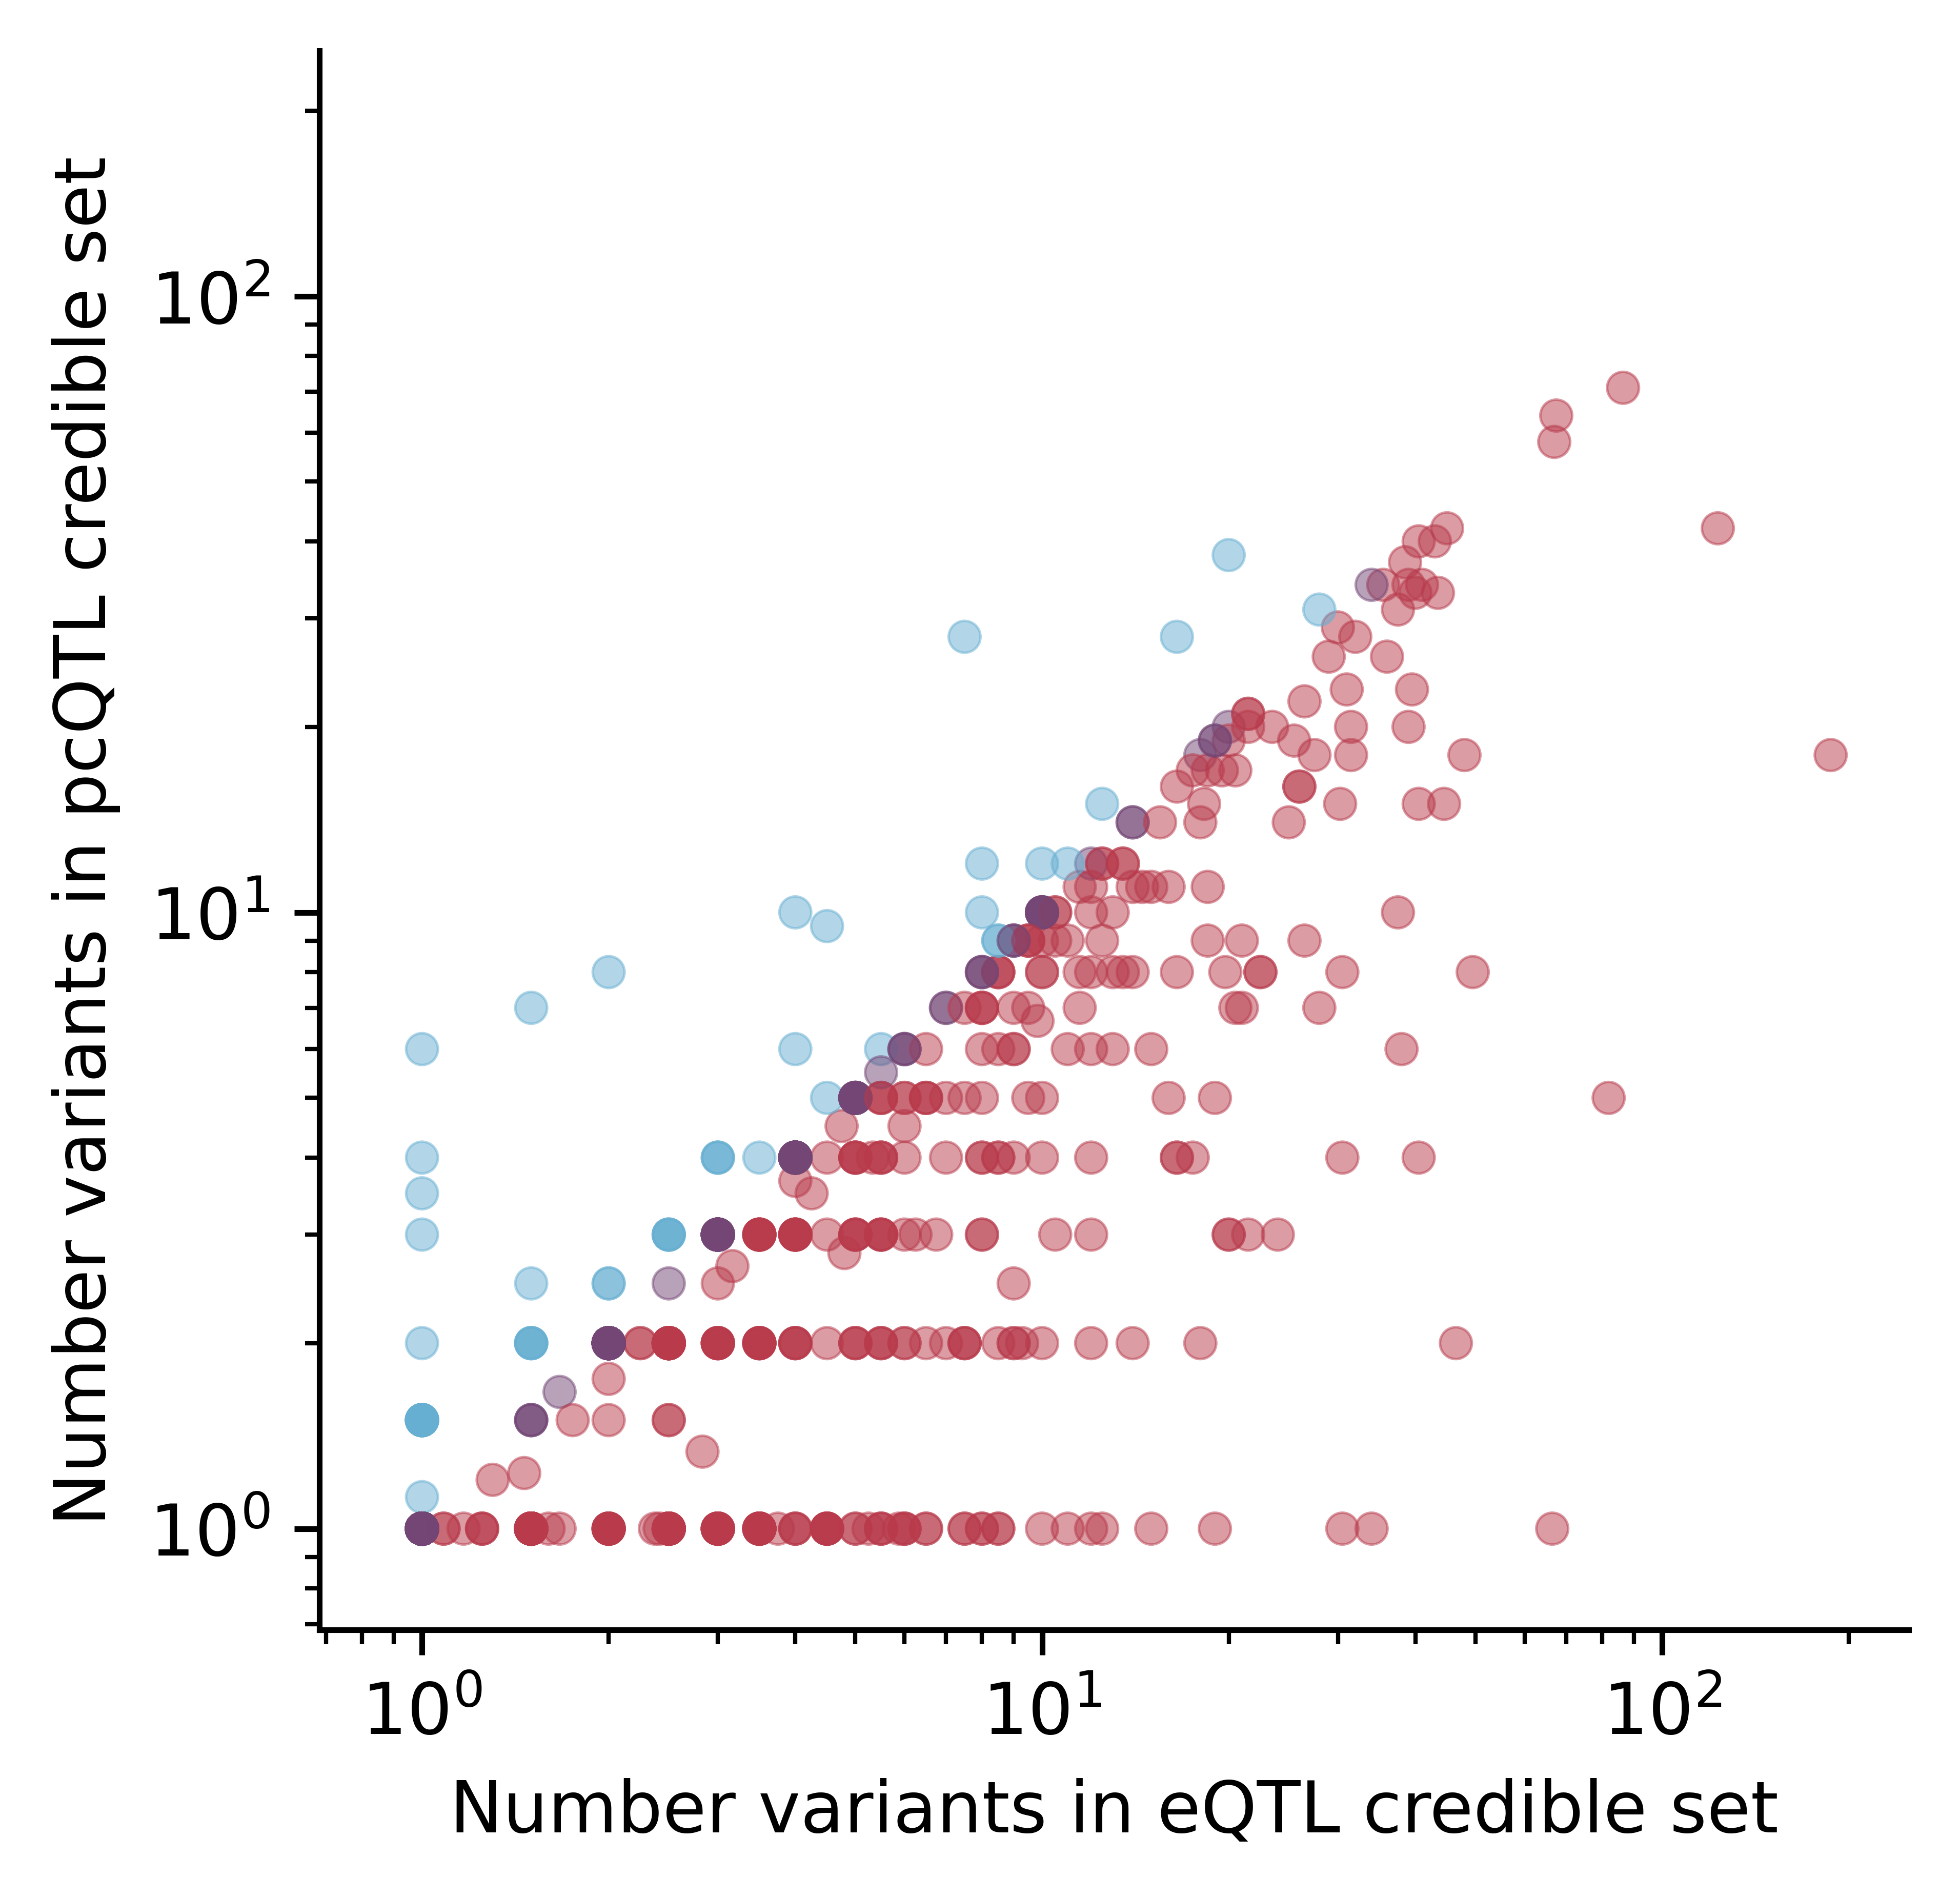

In [49]:
mpl.rcParams['figure.dpi']= 1000

fig, ax = plt.subplots(figsize=(4,4))

sns.scatterplot(cs_sizes_pivot, x='eqtl', y='pcqtl', hue='cs_size_label', 
                palette={'eQTL':'#67AFD2','pcQTL':'#B83A4B', 'same size':'#734675'}, ax=ax, 
                edgecolor=None, s=20, alpha=.5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Number variants in pcQTL credible set')
ax.set_xlabel('Number variants in eQTL credible set')

plt.gca().get_legend().set_frame_on(False)

# Change legend title
leg = ax.get_legend()
leg.set_title('Credible set smaller in:')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

print((cs_sizes_pivot['eqtl'] <= cs_sizes_pivot['pcqtl']).sum()/len(cs_sizes_pivot))
x = cs_sizes_pivot['eqtl']
y = cs_sizes_pivot['pcqtl']
print(ttest_rel(x, y))
print(ranksums(x, y))

ax.set_xlim(0, 250)
ax.set_ylim(0, 250)
ax.get_legend().set_visible(False)

mpl.rcParams['figure.dpi']= 100

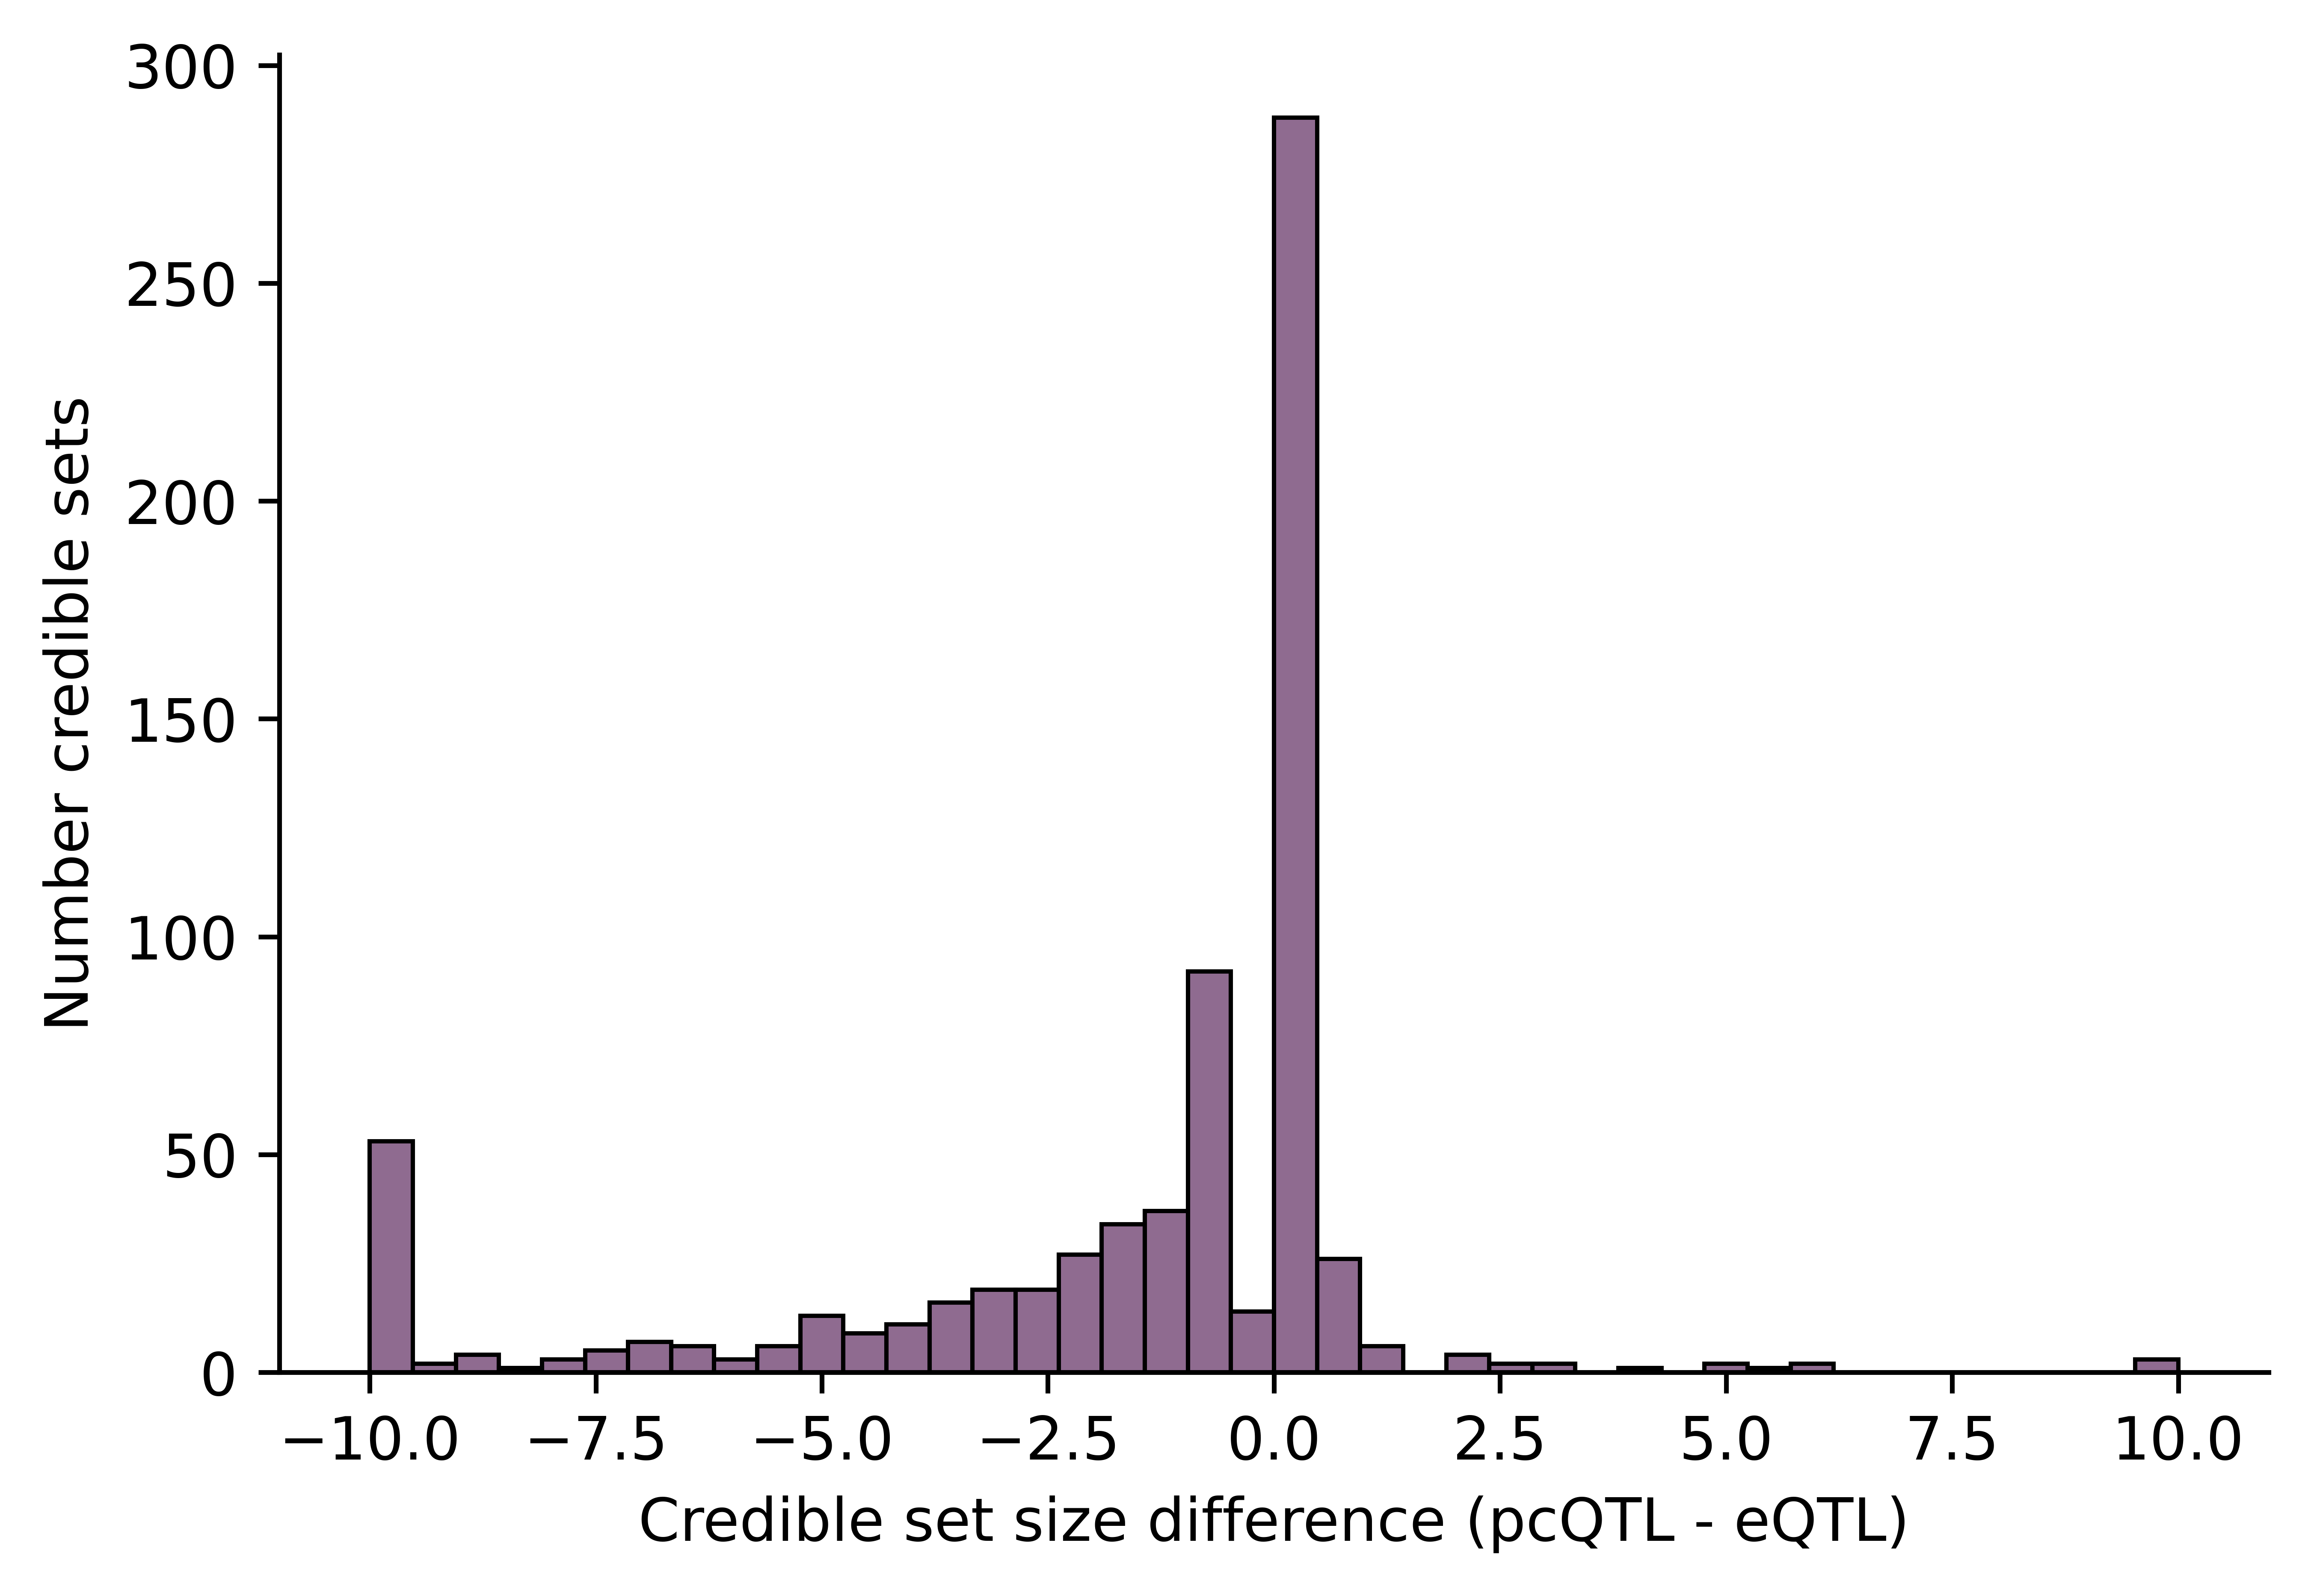

In [62]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 1000
cs_sizes_pivot['size_diff'] = cs_sizes_pivot['pcqtl'] - cs_sizes_pivot['eqtl']
cs_sizes_pivot['size_diff'] = cs_sizes_pivot['size_diff'].clip(-10, 10)
fig, ax = plt.subplots(figsize=(6,4))
sns.histplot(cs_sizes_pivot, x='size_diff', bins = 42, ax=ax, alpha=.8,
             color='#734675')
             #hue='cs_size_label', palette={'eQTL':'#67AFD2','pcQTL':'#B83A4B', 'same size':'#734675'})
ax.set_xlabel('Credible set size difference (pcQTL - eQTL)')
ax.set_ylabel('Number credible sets')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#plt.gca().get_legend().set_frame_on(False)

# Change legend title
#leg = ax.get_legend()
#leg.set_title('Credible set smaller in:')
mpl.rcParams['figure.dpi']= 100



# look at just pc1

In [43]:
# look at just 1st pcs
cs_grouped = cs_grouped[cs_grouped['pc_num'] <2]

# group vep ddf by lead variant
# group by lead variant to prevent varaints from being double counted
lead_var_grouped = cs_grouped.groupby(['lead_variant_id', 'tissue_id', 'cluster_id']).agg({'cs_id':list, 
                                                                                'type':list, 
                                                                                'pc_num':list, 
                                                                                'cluster_size':'first', 
                                                                                'pc_order':list, 
                                                                                'num_vars':list}).reset_index() # you could also do a list of varainces
lead_var_grouped['num_e_samelead'] = lead_var_grouped['cs_id'].astype(str).str.count('_e_')
lead_var_grouped['num_pc_samelead'] = lead_var_grouped['cs_id'].astype(str).str.count('_pc')
lead_var_grouped['exclusive_label'] = np.where((lead_var_grouped['num_e_samelead'] > 0), np.where((lead_var_grouped['num_pc_samelead'] > 0), 'shared', 'eqtl_only'), 'pcqtl_only')

# get the smaller cs for each of the two data types for the shared ones
cs_sizes = lead_var_grouped[lead_var_grouped['exclusive_label']=='shared'].explode(['type', 'num_vars']).sort_values(by=['lead_variant_id', 'tissue_id', 'cluster_id', 'type']).groupby(['lead_variant_id', 'tissue_id', 'cluster_id', 'type']).agg({'num_vars':min, 'cluster_size':'first', 'num_e_samelead':max})
cs_sizes_pivot = cs_sizes.pivot_table(index=['lead_variant_id', 'cluster_size', 'num_e_samelead', 'cluster_id'], 
                           columns='type', 
                           values='num_vars', 
                           fill_value=0).reset_index()


<AxesSubplot: xlabel='cs_size_label', ylabel='count'>

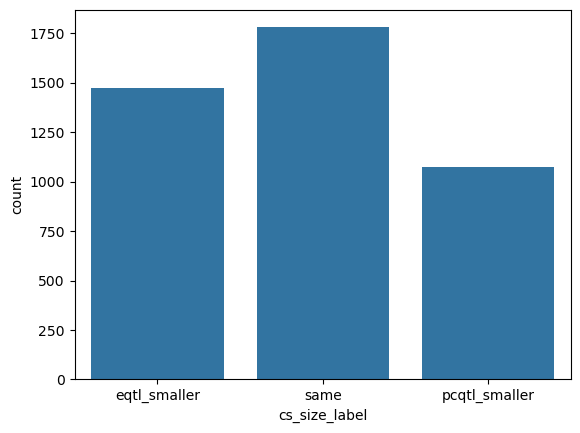

In [22]:
cs_sizes_pivot['cs_size_label'] = np.where(
    cs_sizes_pivot['eqtl'] < cs_sizes_pivot['pcqtl'], 
    'eqtl_smaller', 
    np.where(
        cs_sizes_pivot['eqtl'] > cs_sizes_pivot['pcqtl'], 
        'pcqtl_smaller', 
        'same'
    )
)
sns.countplot(cs_sizes_pivot,  x='cs_size_label')

TtestResult(statistic=-2.6079802655934317, pvalue=0.009139142722163792, df=4324)


NameError: name 'ranksums' is not defined

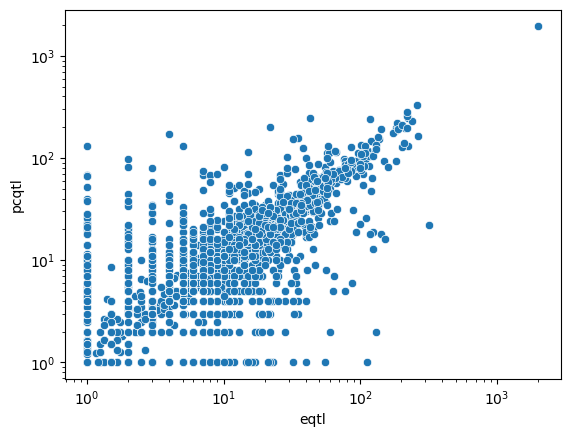

In [23]:
ax = sns.scatterplot(cs_sizes_pivot, x='eqtl', y='pcqtl')
ax.set_xscale('log')
ax.set_yscale('log')
print(ttest_rel(cs_sizes_pivot['eqtl'], cs_sizes_pivot['pcqtl']))
print(ranksums(cs_sizes_pivot['eqtl'], cs_sizes_pivot['pcqtl']))
print((cs_sizes_pivot['eqtl'] <= cs_sizes_pivot['pcqtl']).sum()/len(cs_sizes_pivot))

# high corr clusters?

TtestResult(statistic=-1.5503085412181064, pvalue=0.12137496590444107, df=1029)


NameError: name 'ranksums' is not defined

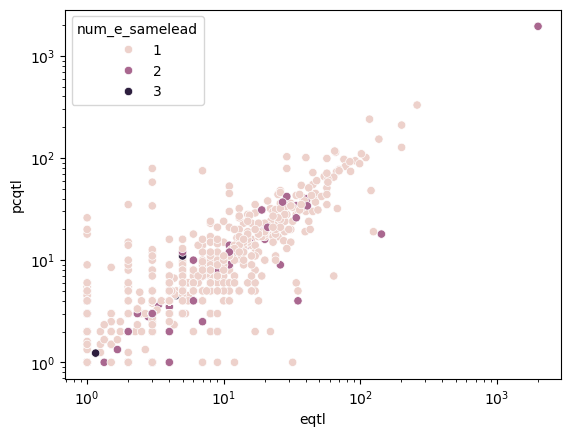

In [24]:
cs_sizes_pivot_high_corr = cs_sizes_pivot[cs_sizes_pivot['cluster_id'].isin(clusters[clusters['abs_cor']>.5]['cluster_id'])]

ax = sns.scatterplot(cs_sizes_pivot_high_corr, x='eqtl', y='pcqtl', hue='num_e_samelead')
ax.set_xscale('log')
ax.set_yscale('log')
print(ttest_rel(cs_sizes_pivot_high_corr['eqtl'], cs_sizes_pivot_high_corr['pcqtl']))
print(ranksums(cs_sizes_pivot_high_corr['eqtl'], cs_sizes_pivot_high_corr['pcqtl']))
print((cs_sizes_pivot_high_corr['eqtl'] < cs_sizes_pivot_high_corr['pcqtl']).sum()/len(cs_sizes_pivot_high_corr))
print((cs_sizes_pivot_high_corr['eqtl'] > cs_sizes_pivot_high_corr['pcqtl']).sum()/len(cs_sizes_pivot_high_corr))